# Reggaeton Clustering

Using the files generated in 1-data_preprocessing.ipynb, I will explore several clustering methods and save the relevant data files to build my reggaeton recommendation system. I opted to use GMM with sparse PCA to cluster and observe my songs. I determine which clustering algorithm was better by manualy checking all the clusters and quantifying the ratio of reggaeton to non-reggaeton songs in each cluster. I selected the hyperparameters based on the elbow method in K-means

## Exploration

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA


from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')


In [20]:
# load dataset with OHE numerical, musical features only and reggaeton label
spotify_df = pd.read_csv("../spotify-datasets/kaggle-yamaerenay-dataset/tracks_JoseCleaned_OHE_musical_features_only.csv")


In [21]:
spotify_df

,duration_ms,explicit,danceability,energy,loudness,mode,speechiness,acousticness,instrumentalness,liveness,...,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5,era_FLAG_1990s,era_FLAG_2000s,era_FLAG_2010s,genres_reggaeton
0,160187,0,0.484,0.2650,-11.101,1,0.0322,0.394,0.000000,0.1490,...,False,False,False,True,False,False,False,True,False,False
1,141987,0,0.405,0.3650,-10.226,0,0.0289,0.255,0.000005,0.1630,...,False,False,False,False,True,False,False,True,False,False
2,157093,0,0.477,0.3520,-14.165,1,0.0300,0.406,0.000000,0.1220,...,False,False,False,False,True,False,False,True,False,False
3,114987,0,0.617,0.7110,-6.433,1,0.0297,0.360,0.000002,0.0841,...,False,False,False,False,True,False,False,True,False,False
4,115240,0,0.409,0.6390,-7.628,1,0.0302,0.288,0.000000,0.3430,...,False,False,False,False,True,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293122,265846,0,0.528,0.6730,-3.639,1,0.0314,0.143,0.000000,0.0989,...,False,False,False,False,True,False,False,False,True,False
293123,82500,0,0.609,0.0172,-28.573,1,0.1180,0.996,0.973000,0.1080,...,False,False,False,False,True,False,False,False,True,False
293124,185250,0,0.562,0.0331,-25.551,1,0.1030,0.996,0.961000,0.1110,...,False,False,False,True,False,False,False,False,True,False
293125,258267,0,0.560,0.5180,-7.471,0,0.0292,0.785,0.000000,0.0648,...,False,False,False,False,True,False,False,False,True,False


In [22]:
spotify_df.columns

Index(['duration_ms', 'explicit', 'danceability', 'energy', 'loudness', 'mode',
       'speechiness', 'acousticness', 'instrumentalness', 'liveness',
       'valence', 'tempo', 'key_1', 'key_2', 'key_3', 'key_4', 'key_5',
       'key_6', 'key_7', 'key_8', 'key_9', 'key_10', 'key_11',
       'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s', 'genres_reggaeton'],
      dtype='object')

### Let's find the optimal number of number of clusters (which will represent genres in a way)

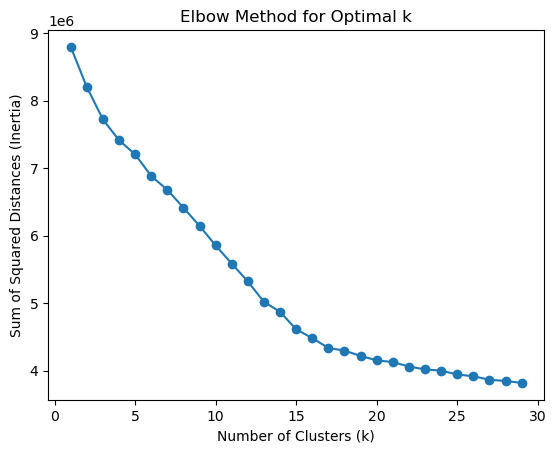

In [25]:
# Extract relevant features and create a feature matrix
feature_columns = ['duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s']   #all except reggaeton flag

df_features = spotify_df[feature_columns]

# Normalize the feature matrix
scaler = StandardScaler()
normalized_feature_matrix = scaler.fit_transform(df_features)

# Specify a range of values for k
k_values = range(1, 30)  # You can adjust the range based on your preference

# Calculate sum of squared distances (inertia) for each value of k
inertia_values = []
for k in k_values:
    kmeans_model = KMeans(n_clusters=k, random_state=42)
    kmeans_model.fit(normalized_feature_matrix)
    inertia_values.append(kmeans_model.inertia_)

# Plot the elbow curve
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances (Inertia)')
plt.title('Elbow Method for Optimal k')
plt.show()


I settle for 16 clusters.

# 2-D PCA

In [6]:
# PCA

# Extract relevant features and create a feature matrix
feature_columns = ['duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s']   #all except reggaeton flag

df_features = spotify_df[feature_columns]

#scale
scaler = StandardScaler()
normalized_feature_matrix = scaler.fit_transform(df_features)

#instantiate
pca = PCA(n_components=2, 
          random_state=42)

#fit
my_pca = pca.fit_transform(normalized_feature_matrix)

In [7]:
pcaDf = pd.DataFrame(my_pca, index = df_features.index) # save to df
pcaDf['Reggaeton'] = spotify_df['genres_reggaeton'] # add reggaeton label

In [8]:
pcaDf

,0,1,Reggaeton
0,3.547236,2.728356,False
1,0.293234,-0.297039,False
2,1.009397,-0.633263,False
3,-1.248000,-0.336890,False
4,-0.929859,0.149349,False
...,...,...,...
293122,-0.791514,0.305765,False
293123,3.937684,-1.662082,False
293124,6.507750,2.264131,False
293125,0.639912,0.065310,False


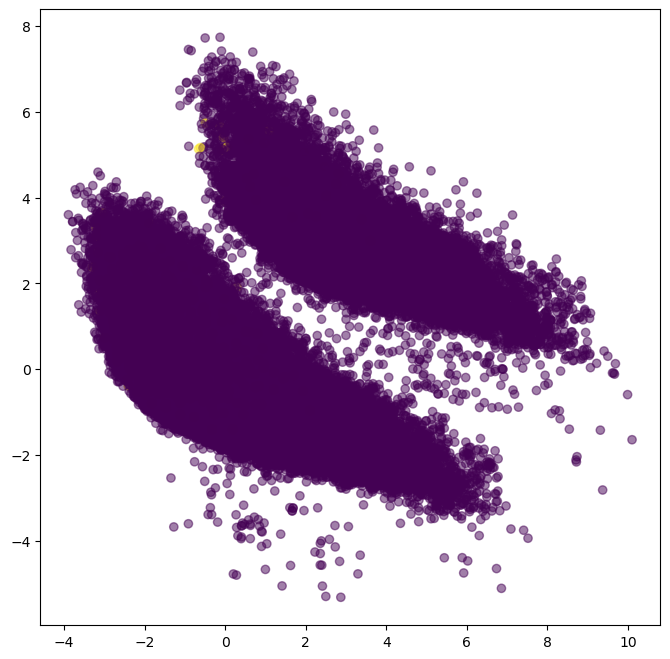

In [9]:
# plot
plt.figure(figsize=(8,8))
plt.scatter(pcaDf[0], pcaDf[1], c=pcaDf['Reggaeton'], alpha=0.5)
plt.show()

In [10]:
loadingsDf = pd.DataFrame(pca.components_, columns=list(df_features.columns))

<Axes: >

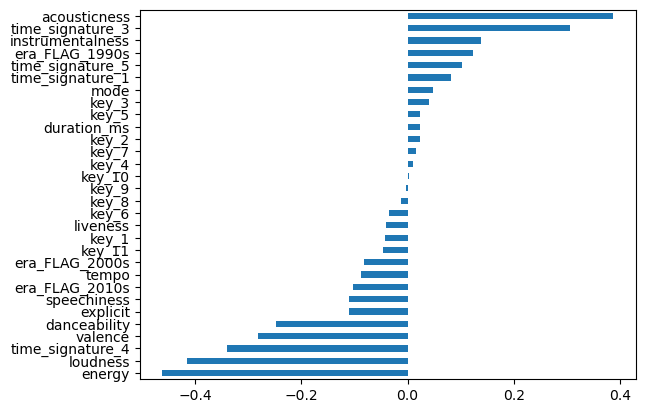

In [11]:
loadingsDf.iloc[0,:].sort_values(ascending=True).plot(kind='barh')

<Axes: >

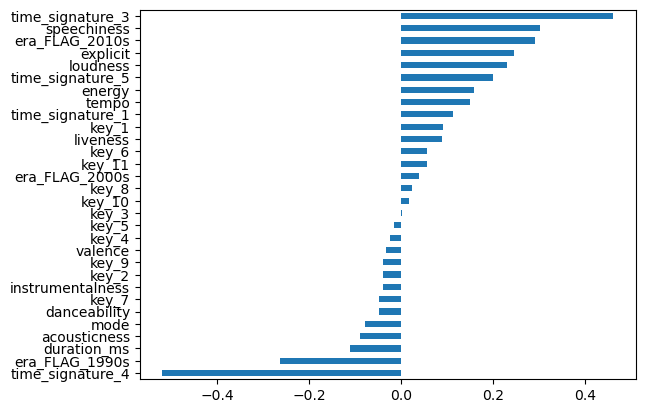

In [12]:
loadingsDf.iloc[1,:].sort_values(ascending=True).plot(kind='barh')

### The data is anisotropically distributed data. K-Means is not great with it. I should try DBSCAN and/or GAUSSIAN MIXTURE.

Sources of info on this:
- https://zerowithdot.com/mistakes-with-k-means-clustering/
- https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html
- https://scikit-learn.org/stable/modules/clustering.html

In [13]:
from sklearn.decomposition import SparsePCA
# sparse PCA for the lolz

# Extract relevant features and create a feature matrix
feature_columns = ['duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s']   #all except reggaeton flag

df_features = spotify_df[feature_columns]

#scale
scaler = StandardScaler()
normalized_feature_matrix = scaler.fit_transform(df_features)

#instantiate
pca = SparsePCA(n_components=2, 
                random_state=42,
                alpha=10,
                verbose=True)

#fit
my_pca = pca.fit_transform(normalized_feature_matrix)

pcaDf = pd.DataFrame(my_pca, index = df_features.index) # save to df
pcaDf['Reggaeton'] = spotify_df['genres_reggaeton'] # add reggaeton label

[dict_learning] ..........................................................................................................................................


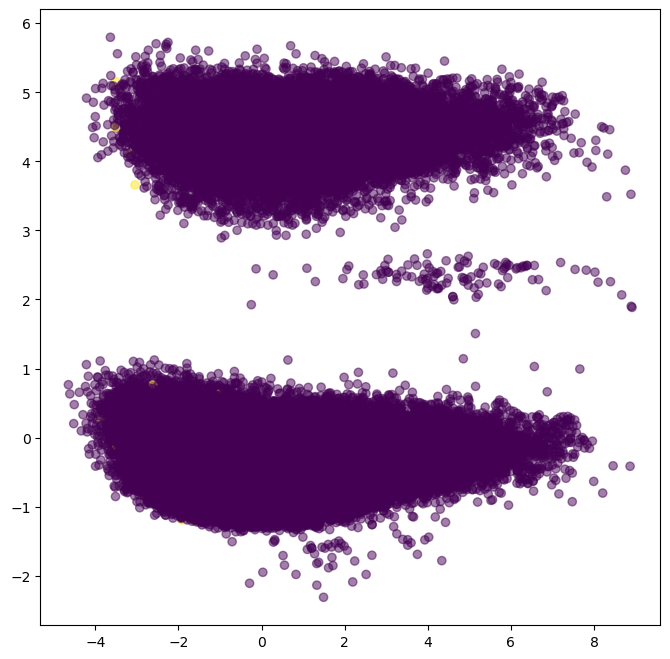

In [14]:
# plot
plt.figure(figsize=(8,8))
plt.scatter(pcaDf[0], pcaDf[1], c=pcaDf['Reggaeton'], alpha=0.5)
plt.show()

In [15]:
loadingsDf = pd.DataFrame(pca.components_, columns=list(df_features.columns))

<Axes: >

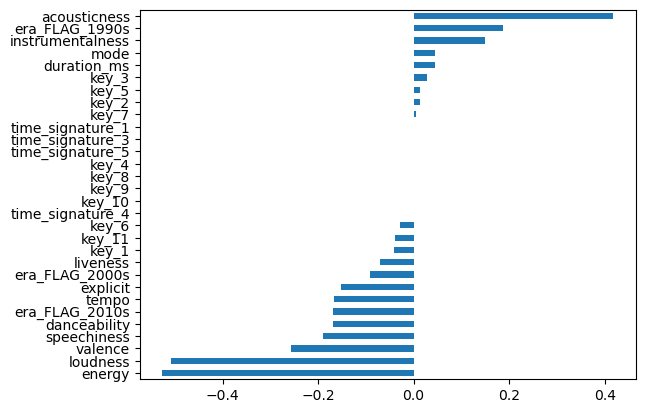

In [16]:
loadingsDf.iloc[0,:].sort_values(ascending=True).plot(kind='barh')

<Axes: >

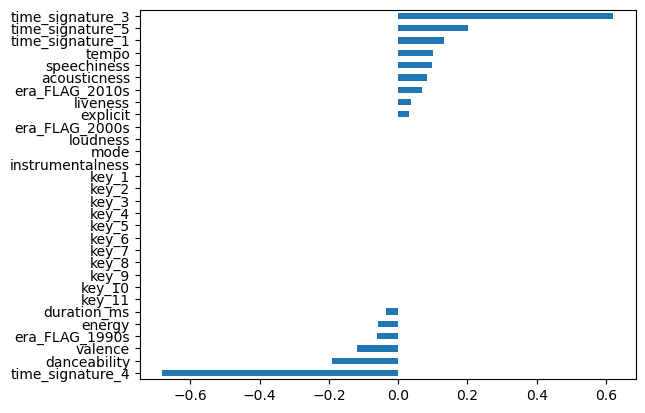

In [17]:
loadingsDf.iloc[1,:].sort_values(ascending=True).plot(kind='barh')

### 3-D plot

In [29]:
# PCA

# Extract relevant features and create a feature matrix
feature_columns = ['duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s']   #all except reggaeton flag

df_features = spotify_df[feature_columns]

#scale
scaler = StandardScaler()
normalized_feature_matrix = scaler.fit_transform(df_features)

#instantiate
pca = PCA(n_components=3, 
          random_state=42)

#fit
my_pca = pca.fit_transform(normalized_feature_matrix)

pcaDf = pd.DataFrame(my_pca, index = df_features.index) # save to df
pcaDf['Reggaeton'] = spotify_df['genres_reggaeton'] # add reggaeton label

# plot
#import plotly.express as px
#import plotly.offline as pyo
#pyo.init_notebook_mode()
#px.scatter_3d(pcaDf, x=0, y=1, z=2, color='Reggaeton', opacity = 0.05)

<Axes: >

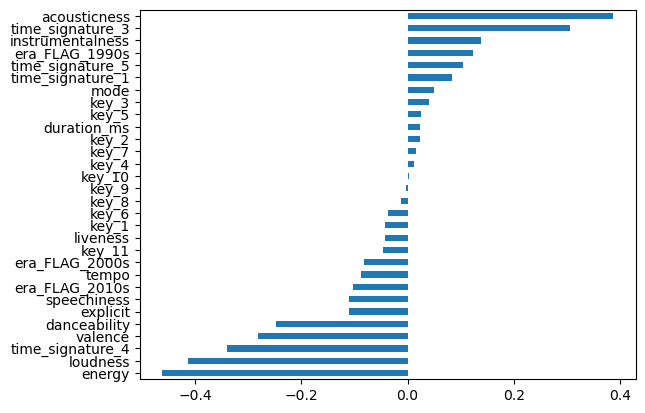

In [45]:
loadingsDf = pd.DataFrame(pca.components_, columns=list(df_features.columns))
loadingsDf.iloc[0,:].sort_values(ascending=True).plot(kind='barh')

<Axes: >

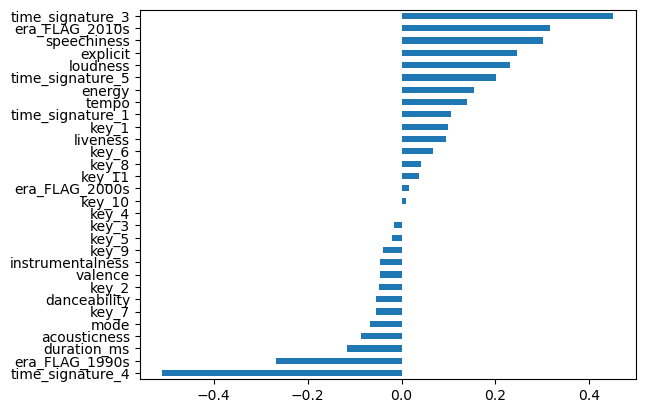

In [46]:
loadingsDf.iloc[1,:].sort_values(ascending=True).plot(kind='barh')

<Axes: >

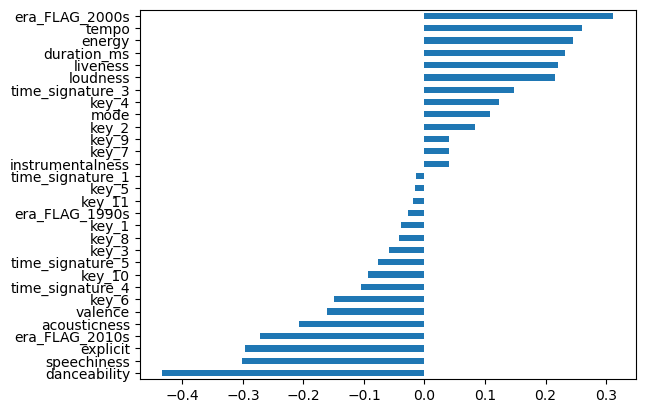

In [47]:
loadingsDf.iloc[2,:].sort_values(ascending=True).plot(kind='barh')

In [28]:
# sparse PCA

# Extract relevant features and create a feature matrix
feature_columns = ['duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s']   #all except reggaeton flag

df_features = spotify_df[feature_columns]

#scale
scaler = StandardScaler()
normalized_feature_matrix = scaler.fit_transform(df_features)

#instantiate
pca = SparsePCA(n_components=3, 
                random_state=42,
                alpha=10,
                verbose=True)

#fit
my_pca = pca.fit_transform(normalized_feature_matrix)

spcaDf = pd.DataFrame(my_pca, index = df_features.index) # save to df
spcaDf['Reggaeton'] = spotify_df['genres_reggaeton'] # add reggaeton label

# plot
#import plotly.express as px
#import plotly.offline as pyo
#pyo.init_notebook_mode()
#px.scatter_3d(spcaDf, x=0, y=1, z=2, color='Reggaeton', opacity = 0.05)

[dict_learning] ..................................................................................................................


### It's clear that most reggaeton clusters together inside one of the two blobs. Now we need to find how to cluster this.

## GMM

In [22]:
from sklearn.mixture import GaussianMixture

# Extract relevant features and create a feature matrix
feature_columns = ['duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s']   #all except reggaeton flag

df_features = spotify_df[feature_columns]

#scale
scaler = StandardScaler()
normalized_feature_matrix = scaler.fit_transform(df_features)


# Initialize 
gmm = GaussianMixture(n_components=16,
                     verbose=True,
                     random_state=42,
                     init_params='random_from_data',
                     warm_start=True)

# Fit and predict
cluster_labels = gmm.fit_predict(normalized_feature_matrix)

Initialization 0
  Iteration 10
Initialization converged: True


In [24]:
spotify_df['GMM_cluster'] = cluster_labels
df_reggaeton_clusters = spotify_df.groupby(['GMM_cluster','genres_reggaeton']).size()
df_reggaeton_clusters = df_reggaeton_clusters.to_frame().reset_index()
df_reggaeton_clusters.rename(columns={0:'reggaeton_count'}, inplace=True)
df_reggaeton_clusters

,GMM_cluster,genres_reggaeton,reggaeton_count
0,0,False,30928
1,0,True,102
2,1,False,15771
3,1,True,96
4,2,False,27254
5,2,True,170
6,3,False,3340
7,3,True,58
8,4,False,32151
9,4,True,121


In [25]:
df_reggaeton_clusters.to_csv("../../../../Desktop/GMM_reggaeton_ratio.csv", index=False)

In [33]:
#sparse PCA
spcaDf['Gaussian_labels'] = cluster_labels
spcaDf['reggaeton'] = spotify_df['genres_reggaeton']

In [35]:
spcaDf['Gaussian_labels'] = spcaDf['Gaussian_labels'].astype(str)

In [26]:
# coloring for GMM clusters
#import plotly.express as px
#import plotly.offline as pyo
#pyo.init_notebook_mode()
#px.scatter_3d(spcaDf, x=0, y=1, z=2, color='Gaussian_labels', opacity = 0.05)

#cluster 11 seems to hold most reggaeton songs

In [27]:
#coloring for reggaeton
#import plotly.express as px
#import plotly.offline as pyo
#pyo.init_notebook_mode()
#px.scatter_3d(spcaDf, x=0, y=1, z=2, color='reggaeton', opacity = 0.05)

From GMM:
- Cluster 2 has ~10% of all reggaeton songs and the cluster at large was smaller on average
- Cluster 3 has 4% of all reggaeton songs but the cluster at large was smaller on average, and this cluster has the highest reggaeton ration of all GMM and KMeans

Next steps: will take Cluster 3 and find songs closest to my liking by matrix factorization

### K-Means

In [47]:

# Extract relevant features and create a feature matrix
feature_columns = ['duration_ms', 'explicit', 'danceability', 'energy',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'key_1', 'key_2',
       'key_3', 'key_4', 'key_5', 'key_6', 'key_7', 'key_8', 'key_9', 'key_10',
       'key_11', 'time_signature_1', 'time_signature_3', 'time_signature_4',
       'time_signature_5', 'era_FLAG_1990s', 'era_FLAG_2000s',
       'era_FLAG_2010s']   #all except reggaeton flag

df_features = spotify_df[feature_columns]

#scale
scaler = StandardScaler()
normalized_feature_matrix = scaler.fit_transform(df_features)


# Initialize
kmeans = KMeans(n_clusters=16,
                random_state=42,
                n_init=5,
                max_iter=100,
                )

# Fit
kmeans.fit(normalized_feature_matrix)

# Predict
cluster_labels = kmeans.predict(normalized_feature_matrix)

In [48]:
spotify_df['KMeans_cluster'] = cluster_labels
df_reggaeton_clusters = spotify_df.groupby(['KMeans_cluster','genres_reggaeton']).size()
df_reggaeton_clusters = df_reggaeton_clusters.to_frame().reset_index()
df_reggaeton_clusters.rename(columns={0:'reggaeton_count'}, inplace=True)
df_reggaeton_clusters

,KMeans_cluster,genres_reggaeton,reggaeton_count
0,0,False,14669
1,0,True,137
2,1,False,31156
3,1,True,138
4,2,False,23073
5,2,True,104
6,3,False,18231
7,3,True,8
8,4,False,8259
9,4,True,33


In [49]:
df_reggaeton_clusters.to_csv("../../../../Desktop/KMeans_reggaeton_ratio.csv", index=False)

I found three clusters that were good candidates (0, 6, and 13), but none are better than GMM's cluster 3

In [50]:
spcaDf['Kmeans_labels'] = cluster_labels
spcaDf['Kmeans_labels'] = spcaDf['Kmeans_labels'].astype(str)

In [31]:
# coloring for Kmeans clusters
#import plotly.express as px
#import plotly.offline as pyo
#pyo.init_notebook_mode()
#px.scatter_3d(spcaDf, x=0, y=1, z=2, color='Kmeans_labels', opacity = 0.05)

In [30]:
# coloring for Kmeans clusters
#import plotly.express as px
#import plotly.offline as pyo
#pyo.init_notebook_mode()
#px.scatter_3d(spcaDf, x=0, y=1, z=2, color='reggaeton', opacity = 0.05)

In [56]:
spotify_df.to_csv("../../Reggaeton_Recommender_System/spotify-datasets/kaggle-yamaerenay-dataset//clustered_spotify_df.csv", index=False)

### Tried DBSCAN and it was too heavy to run. Also, silhouettes scores never ran for me